In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
df = pd.read_csv(r'/Users/beyzanurcakir/Desktop/customer_training_data.csv')

In [8]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^a-z0-9\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['instruction'] = df['instruction'].apply(preprocess_text)


In [10]:
df['intent_code'] = pd.Categorical(df['intent']).codes
num_labels = len(df['intent'].unique())


In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
tokenized_data = tokenizer(list(df['instruction']), padding=True, truncation=True, return_tensors="pt")


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    tokenized_data['input_ids'], 
    torch.tensor(df['intent_code'].values, dtype=torch.long), 
    test_size=0.2, 
    random_state=42)


In [18]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [20]:

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

losses = []
print("Eğitim Başlıyor.")
for epoch in range(5):  # Daha fazla epoch ile performans artırılabilir
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)[0]
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Eğitim Başlıyor...
Epoch 1, Loss: 1.1309585758662295
Epoch 2, Loss: 0.07044782715300764
Epoch 3, Loss: 0.022125491325000655
Epoch 4, Loss: 0.009076186593682948
Epoch 5, Loss: 0.00540731959907654


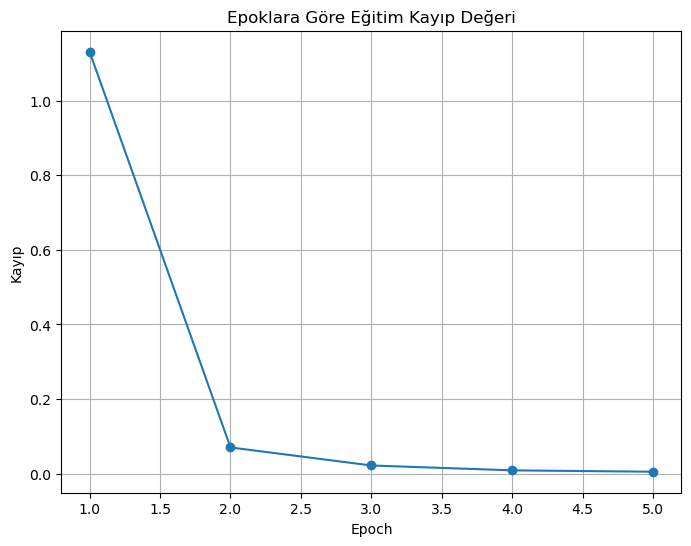

In [22]:
# Öğrenme Eğrisi
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title("Epoklara Göre Eğitim Kayıp Değeri")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.grid()
plt.show()


In [24]:
# Değerlendirme
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)[0]
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       187
           1       1.00      0.99      1.00       187
           2       1.00      1.00      1.00       216
           3       1.00      1.00      1.00       199
           4       1.00      0.99      1.00       192
           5       1.00      1.00      1.00       206
           6       1.00      1.00      1.00       200
           7       1.00      1.00      1.00       203
           8       1.00      1.00      1.00       208
           9       1.00      1.00      1.00       201
          10       1.00      1.00      1.00       217
          11       0.99      1.00      1.00       178
          12       1.00      1.00      1.00       218
          13       1.00      1.00      1.00       171
          14       1.00      1.00      1.00       186
          15       1.00      1.00      1.00       215
          16       0.99      0.99      0.99       196
          17       1.00    

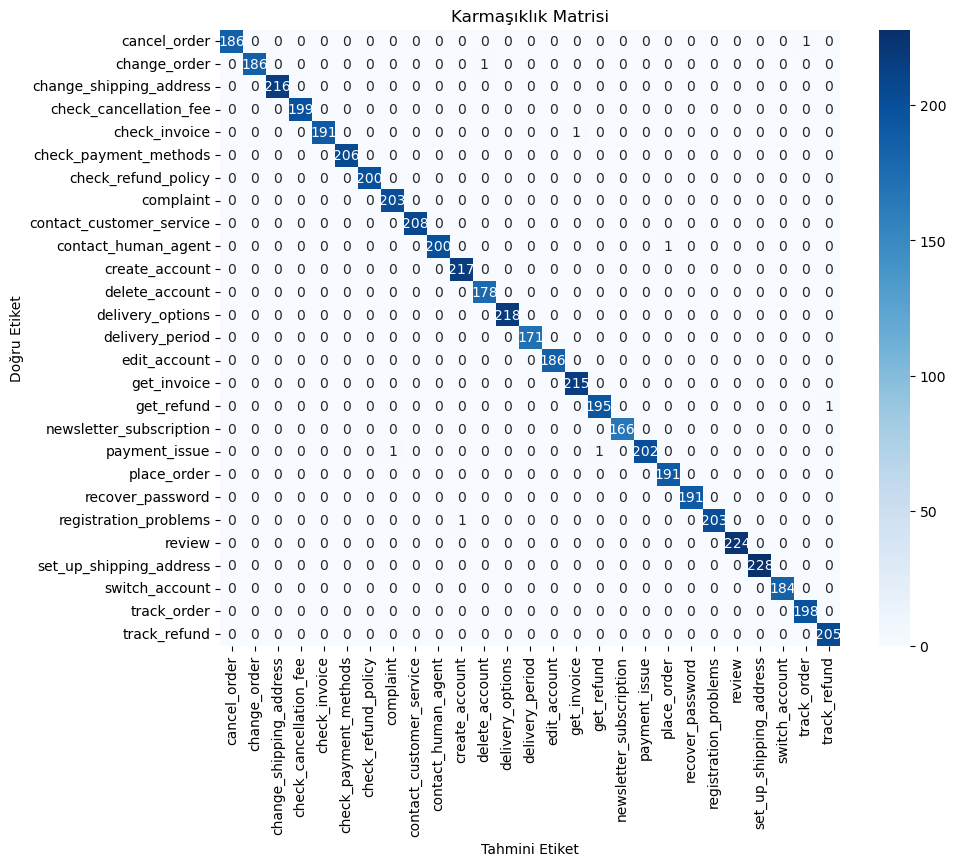

In [26]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=pd.Categorical(df['intent']).categories, 
            yticklabels=pd.Categorical(df['intent']).categories)
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmini Etiket")
plt.ylabel("Doğru Etiket")
plt.show()

In [28]:
# TSNE Görselleştirme
model.eval()
embeddings = []

with torch.no_grad():
    for i in range(0, tokenized_data['input_ids'].size(0), 16):  # Mini-batch ile çalışıyoruz
        batch_inputs = tokenized_data['input_ids'][i:i+16].to(device)
        outputs = model(batch_inputs)[0]
        embeddings.append(outputs.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)


In [29]:
# TSNE kullanarak boyut indirgeme
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


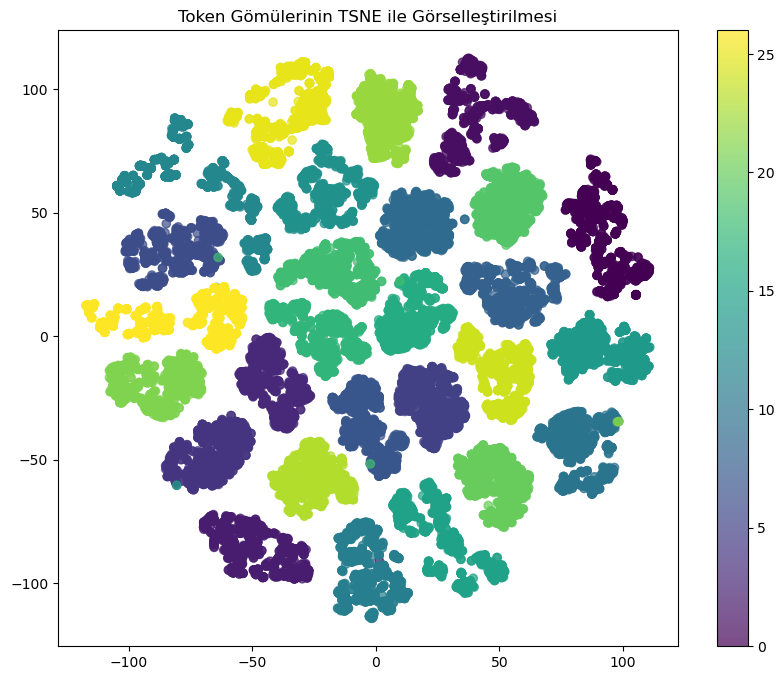

In [30]:
# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['intent_code'], cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("Token Gömülerinin TSNE ile Görselleştirilmesi")
plt.show()


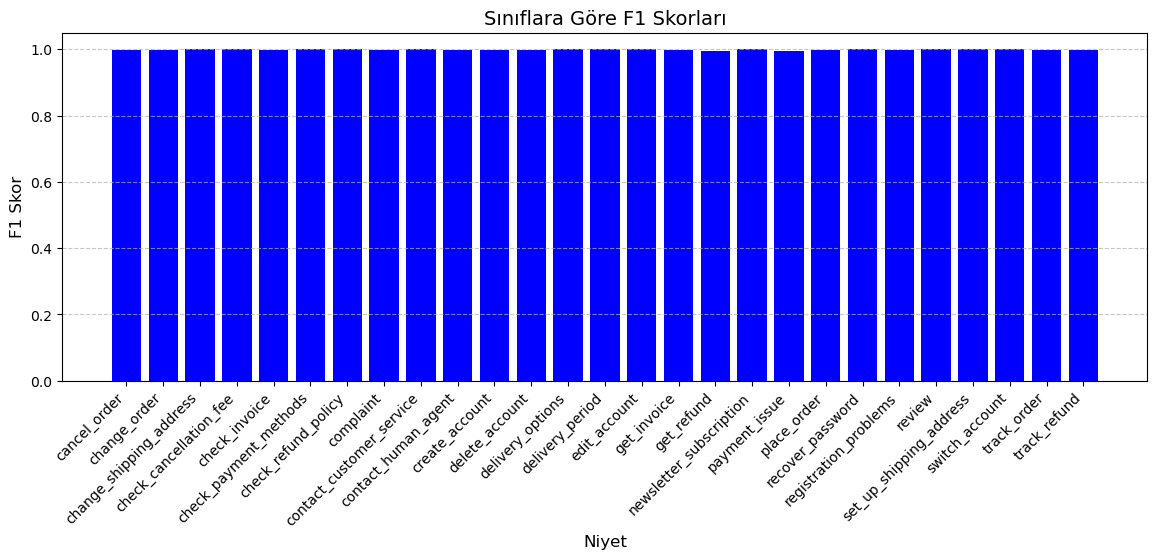

In [49]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Örnek veriler (mevcut kodunuzu buraya entegre edin)
report = classification_report(all_labels, all_preds, target_names=pd.Categorical(df['intent']).categories, output_dict=True)
f1_scores = [v['f1-score'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]

# Bar grafiği
plt.figure(figsize=(14, 6))  # Grafik boyutunu artırdık
plt.bar(pd.Categorical(df['intent']).categories, f1_scores, color='blue')

# Etiket ayarları
plt.title("Sınıflara Göre F1 Skorları", fontsize=14)
plt.xlabel("Niyet", fontsize=12)
plt.ylabel("F1 Skor", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Yazılar 45 derece döndürülüp sağa yaslandı
plt.subplots_adjust(bottom=0.3)  # Alt boşluk artırıldı
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Grafiği göster
plt.show()


In [36]:
# Performans metriklerini görselleştirme
precision_scores = [v['precision'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]
recall_scores = [v['recall'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]


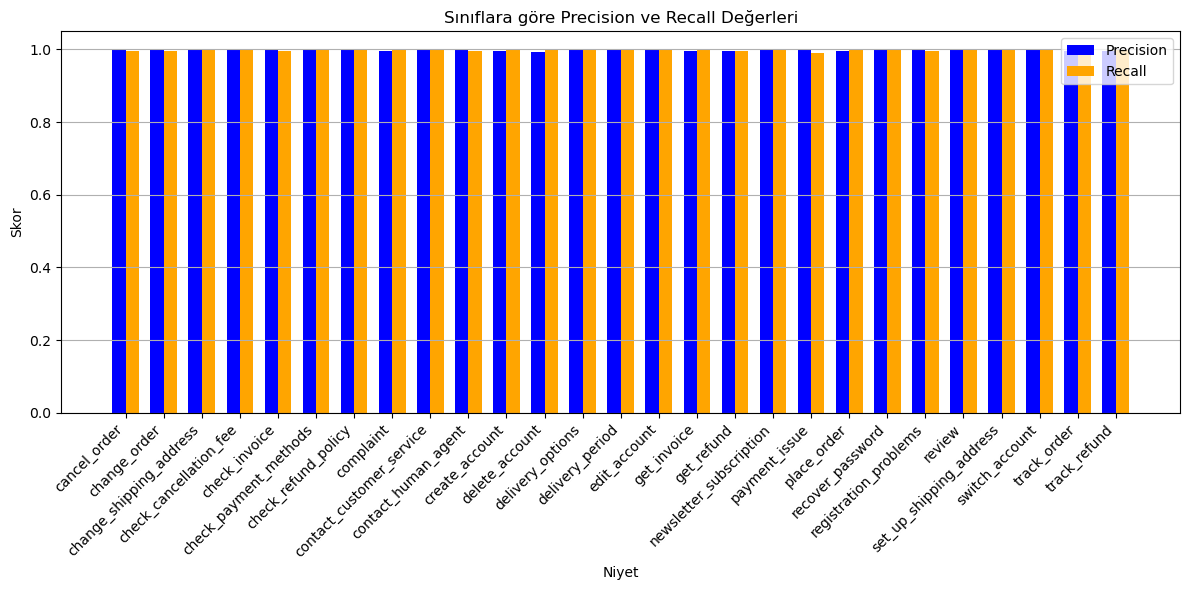

In [38]:
# Precision ve Recall grafiği
x_labels = pd.Categorical(df['intent']).categories

plt.figure(figsize=(12, 6))
x = np.arange(len(x_labels))
width = 0.35

plt.bar(x - width/2, precision_scores, width, label='Precision', color='blue')
plt.bar(x + width/2, recall_scores, width, label='Recall', color='orange')

plt.title("Sınıflara göre Precision ve Recall Değerleri")
plt.xlabel("Niyet")
plt.ylabel("Skor")
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [40]:
# Tahmin fonksiyonu
def predict_intent(user_input):
    user_input = preprocess_text(user_input)  # Tahmin sırasında da ön işleme uygula
    tokens = tokenizer([user_input], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens)[0]
        predicted_intent_code = torch.argmax(outputs, dim=1).item()
    predicted_intent = pd.Categorical(df['intent']).categories[predicted_intent_code]
    return predicted_intent

In [42]:
# Örnek kullanım
user_input = "I need help cancelling my order"
predicted_intent = predict_intent(user_input)
print(f"Predicted Intent: {predicted_intent}")


Predicted Intent: cancel_order


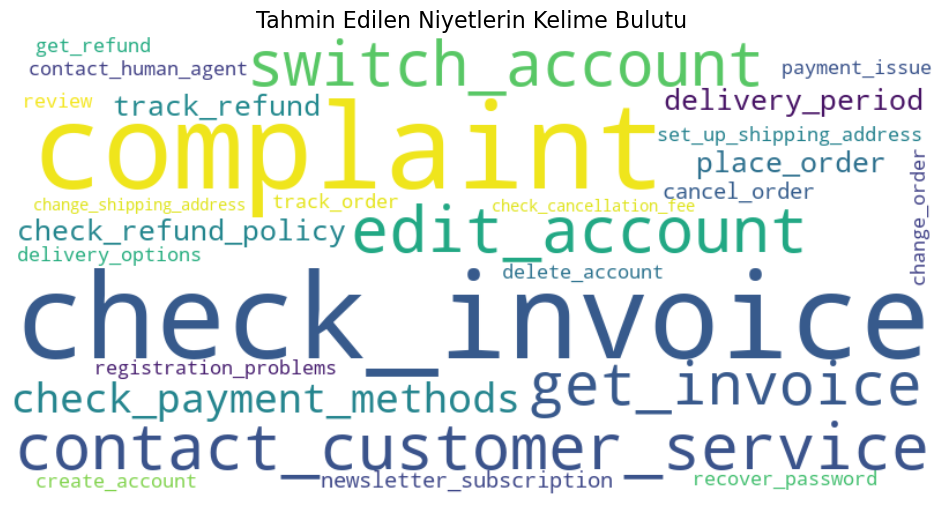

In [52]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tahmin edilen intentleri toplamak için bir liste
predicted_intents = []

# Tüm instruction sütunundaki metinler üzerinden tahmin yapıyoruz
for instruction in df['instruction']:
    predicted_intent = predict_intent(instruction)  # Mevcut tahminleme fonksiyonunuz
    predicted_intents.append(predicted_intent)

# Intentlerin frekansını hesapla
intent_frequencies = Counter(predicted_intents)

# Eğer frekanslar boşsa uyarı ver
if not intent_frequencies:
    print("Tahmin edilen intentler listesi boş. Model çıktısını kontrol edin.")
else:
    # Kelime bulutunu oluştur
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', colormap='viridis'
    ).generate_from_frequencies(intent_frequencies)

    # Kelime bulutunu görselleştir
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Tahmin Edilen Niyetlerin Kelime Bulutu', fontsize=16)
    plt.show()


NameError: name 'classification_report' is not defined